In [17]:
from PIL import Image
import numpy as np
import random
import time
import pygame
import sys
from pygame.locals import *

In [5]:
# Source of perlin noise https://stackoverflow.com/questions/42147776/producing-2d-perlin-noise-with-numpy

def perlin(x,y,): # seed=0):
    # permutation table
    # np.random.seed(seed)
    p = np.arange(256,dtype=int)
    np.random.shuffle(p)
    p = np.stack([p,p]).flatten()
    # coordinates of the top-left
    xi = x.astype(int)
    yi = y.astype(int)
    # internal coordinates
    xf = x - xi
    yf = y - yi
    # fade factors
    u = fade(xf)
    v = fade(yf)
    # noise components
    n00 = gradient(p[p[xi]+yi],xf,yf)
    n01 = gradient(p[p[xi]+yi+1],xf,yf-1)
    n11 = gradient(p[p[xi+1]+yi+1],xf-1,yf-1)
    n10 = gradient(p[p[xi+1]+yi],xf-1,yf)
    # combine noises
    x1 = lerp(n00,n10,u)
    x2 = lerp(n01,n11,u) # FIX1: I was using n10 instead of n01
    return lerp(x1,x2,v) # FIX2: I also had to reverse x1 and x2 here

def lerp(a,b,x):
    "linear interpolation"
    return a + x * (b-a)

def fade(t):
    "6t^5 - 15t^4 + 10t^3"
    return 6 * t**5 - 15 * t**4 + 10 * t**3

def gradient(h,x,y):
    "grad converts h to the right gradient vector and return the dot product with (x,y)"
    vectors = np.array([[0,1],[0,-1],[1,0],[-1,0]])
    g = vectors[h%4]
    return g[:,:,0] * x + g[:,:,1] * y

# lin = np.linspace(0,5,100,endpoint=False)
# x,y = np.meshgrid(
#     np.linspace(0,2,35,endpoint=False),
#     np.linspace(0,2,35,endpoint=False)) 
#     # FIX3: I thought I had to invert x and y here but it was a mistake

# plt.imshow(perlin(x,y,seed=2))

In [6]:
# Colors are dark and bright
WARRIOR_COLORS = (((30,30,30), (200,200,200)),
                  ((0,0,100), (0,0,255)),
                  ((0,100,0), (0,255,0)),
                #   ((100,0,0), (255,0,0)),
                  ((0,100,100), (0,255,255)),
                  ((100,0,100), (255,0,255)),
                  ((66,66,100), (170,170,255)),
                  ((100,66,66), (255,170,170)),
                  ((66,100,66), (170,255,170)),
                  ((100,100,0), (255,255,0)),
                  ((0,0,100), (0,0,255)),
                  ((0,100,0), (0,255,0)),
                #   ((100,0,0), (255,0,0)),
                  ((0,100,100), (0,255,255)),
                  ((100,0,100), (255,0,255)),
                  ((66,66,100), (170,170,255)),
                  ((100,66,66), (255,170,170)),
                  ((66,100,66), (170,255,170)),
                  ((100,100,0), (255,255,0)))

WARRIOR_COLORS = (((0,0,170), (200,200,200)),
                  ((0,204,85), (0,0,255)),
                  ((0,204,85), (0,0,255)),
                  ((0,204,85), (0,0,255)),
                  ((0,204,85), (0,0,255)),
                  ((0,204,85), (0,0,255)),
                  ((0,204,85), (0,0,255)),
                  ((0,204,85), (0,0,255)),
                  ((0,204,85), (0,0,255)),
                  ((0,204,85), (0,0,255)),
                  ((0,204,85), (0,0,255)),
                  ((0,204,85), (0,0,255)),
                  ((0,204,85), (0,0,255)),
                  ((0,204,85), (0,0,255)),
                  ((0,204,85), (0,0,255)),
                  ((0,204,85), (0,0,255)),
 
                  ((100,100,0), (255,255,0)))

# WARRIOR_COLORS = (((70,70,70), (125,125,125)),
#                   ((5,5,5), (0,0,255)),
#                   ((5,5,5), (0,0,255)),
#                   ((5,5,5), (0,0,255)),
#                   ((5,5,5), (0,0,255)),
#                   ((5,5,5), (0,0,255)),
#                   ((5,5,5), (0,0,255)),
#                   ((5,5,5), (0,0,255)),
#                   ((5,5,5), (0,0,255)),
#                   ((5,5,5), (0,0,255)),
#                   ((5,5,5), (0,0,255)),
#                   ((5,5,5), (0,0,255)),
#                   ((5,5,5), (0,0,255)),
#                   ((5,5,5), (0,0,255)),
#                   ((5,5,5), (0,0,255)),
#                   ((5,5,5), (0,0,255)),
#                   ((100,100,0), (255,255,0)))

wc_arr = np.array(WARRIOR_COLORS, dtype=np.uint8)

# specify the image size
shape = (125, 64)

In [7]:
# read change rate, write change rate, consumption
rcr = 0.3
wcr = 0.7
ccr = 0.2
sccr = 0.2
# memory unit pixel size
ps = 7
pad = 2
consumption_pad = ps * 8
ps2 = ps**2

pad_max = np.max([pad, consumption_pad])

In [8]:
# reading the initial frame
i = 0
init_record = np.load("../games/test_"+str(i)+".npz")["record"]
# reshaping to the image size
rs_init_record = init_record.reshape((shape[0], shape[1], 6))
# coloring based on the writer warrior
# reader warrior index: 4
# writer warrior index: 5
img = Image.fromarray(wc_arr[rs_init_record[:, :, 5], 0])
# increasing the image resolution
img = img.resize((shape[1]*ps, shape[0]*ps), resample=Image.NEAREST)
img_arr = np.pad(np.array(img), ((pad_max, pad_max), (pad_max, pad_max), (0,0)), mode='constant', constant_values=[0])

In [9]:
img_arr.shape

(987, 560, 3)

In [10]:
def spray_read(img_arr, record, pre_record, shape, ps, pad, pad_max, rcr, wc_arr):
    # read the new record
    record = np.load("../games/test_"+str(i)+".npz")["record"]
    
    # find the recent reads by agents
    recent_read = np.argwhere(record[:, 4] != pre_record[:, 4]).flatten()
    # extract the x, y indices
    x_ri, y_ri = np.unravel_index(recent_read, shape)

    # generate the read spray kernels (randomly)
    read_spray_kernel = np.random.rand(recent_read.size, ps + 2*pad, ps + 2 * pad)
    # convert spray to indices
    rsk_index = np.argwhere(read_spray_kernel < rcr)

    
    # Right Side: reads the first element of rsk_index which is the id of the read change in this iteration, and with that index we read the id of the memory unit that has been changed from the recent_read, and with the memory unit id and 4 (read) we read the id of the agent that has executed the read, and we use this agent id to extract the color of the agent from wc_arr

    # Left Side: reads the first element of rsk_index which is the id of the read change in this iteration, and with that we read the x index that corresponds to the memory unit and multiply it with the pixel scale to find the top-left corner of the representing area in the high-resolution image, then we add the rsk_index column 1 to find the randomly selected pixel in the area that we need to change its color
    # print((x_ri[rsk_index[:, 0]] * ps + rsk_index[:, 1]).shape, (y_ri[rsk_index[:, 0]] * ps + rsk_index[:, 2]).shape)
    # print(img_arr[x_ri[rsk_index[:, 0]] * ps + rsk_index[:, 1], y_ri[rsk_index[:, 0]] * ps + rsk_index[:, 2]])
    img_arr[x_ri[rsk_index[:, 0]] * ps + pad_max - pad + rsk_index[:, 1], y_ri[rsk_index[:, 0]] * ps + pad_max - pad + rsk_index[:, 2]] = wc_arr[record[recent_read[rsk_index[:, 0]], 4], 0]

    return img_arr


def spray_write(img_arr, record, pre_record, shape, ps, pad, pad_max, wcr, wc_arr):
    # find the recent reads by agents
    recent_write = np.argwhere(record[:, 5] != pre_record[:, 5]).flatten()
    # extract the x, y indices
    x_wi, y_wi = np.unravel_index(recent_write, shape)

    # generate the read spray kernels (randomly)
    write_spray_kernel = np.random.rand(recent_write.size, ps, ps)
    # convert spray to indices
    wsk_index = np.argwhere(write_spray_kernel < wcr)

    img_arr[x_wi[wsk_index[:, 0]] * ps + pad_max - pad + wsk_index[:, 1], y_wi[wsk_index[:, 0]] * ps + pad_max - pad + wsk_index[:, 2]] = wc_arr[record[recent_write[wsk_index[:, 0]], 4], 0]
    
    return img_arr

def spray_self_consumption(img_arr, record, pre_record, shape, ps, pad, pad_max, sccr, wc_arr):
    # consumption condition are threefold:
    # 1. an action of read has executed at this memory unit
    # 2. the agent responsible for the read action is different from the agent that has lastly written in the same unit
    # 3. the agent responsible for the last write action is not 0 (which is the initialization action)
    recent_consumption = np.argwhere((record[:, 4] != pre_record[:, 4]) * (record[:, 4] == record[:, 5])* (record[:, 4] != 0)).flatten()
    # extract the x, y indices
    x_wi, y_wi = np.unravel_index(recent_consumption, shape)

    if recent_consumption.size > 0:
        # # generate the consumption spray kernels (randomly)
        # consumption_spray_kernel = np.random.rand(recent_consumption.size, ps + consumption_pad * 2, ps + consumption_pad * 2)
        # generate the consumption spray kernels (with perlin noise)
        noise_shape = (recent_consumption.size, ps + consumption_pad * 2, ps + consumption_pad * 2)
        consumption_spray_kernel = perlin(*np.meshgrid(
            np.linspace(0,2,noise_shape[0]* noise_shape[1],endpoint=False),
            np.linspace(0,2,noise_shape[2],endpoint=False))).reshape(noise_shape)
        
        consumption_spray_kernel -= consumption_spray_kernel.min() 
        consumption_spray_kernel /= consumption_spray_kernel.max()
        # all indices
        indices = np.argwhere(consumption_spray_kernel[0] + 0.0000001 >0)
        # distance of all cells to each other
        # # matrix of z indices
        # m = np.tile(indices, indices.shape[0]).reshape((indices.shape[0], indices.shape[0], 2))
        # # transpose of z indices
        # mt = m.transpose((1,0,2))
        # # computing the distance of all cells to each other
        # np.abs(m-mt).sum(axis=2)

        center_index = np.floor_divide(np.array(consumption_spray_kernel[0].shape), 2)
        dists = np.abs(indices - center_index).sum(axis=1)
        central_weights = dists / dists.max()

        # average of random kernel with distance to center
        consumption_spray_kernel = 0.7 * consumption_spray_kernel + 0.3 * central_weights.reshape(consumption_spray_kernel[0].shape) 
        # convert spray to indices
        csk_index = np.argwhere(consumption_spray_kernel < sccr)

        img_arr[x_wi[csk_index[:, 0]] * ps + pad_max - pad + csk_index[:, 1], y_wi[csk_index[:, 0]] * ps + pad_max - pad + csk_index[:, 2]] = np.array([140, 1, 26])
    
    return img_arr

def spray_consumption(img_arr, record, pre_record, shape, ps, pad, pad_max, ccr, wc_arr):
    # consumption condition are threefold:
    # 1. an action of read has executed at this memory unit
    # 2. the agent responsible for the read action is different from the agent that has lastly written in the same unit
    # 3. the agent responsible for the last write action is not 0 (which is the initialization action)
    recent_consumption = np.argwhere((record[:, 4] != pre_record[:, 4]) * (record[:, 4] != record[:, 5]) * (record[:, 4] != 0)).flatten()
    # extract the x, y indices
    x_wi, y_wi = np.unravel_index(recent_consumption, shape)
    
    if recent_consumption.size > 0:
        # # generate the consumption spray kernels (randomly)
        # consumption_spray_kernel = np.random.rand(recent_consumption.size, ps + consumption_pad * 2, ps + consumption_pad * 2)
        # generate the consumption spray kernels (with perlin noise)
        noise_shape = (recent_consumption.size, ps + consumption_pad * 2, ps + consumption_pad * 2)
        consumption_spray_kernel = perlin(*np.meshgrid(
            np.linspace(0,2,noise_shape[0]* noise_shape[1],endpoint=False),
            np.linspace(0,2,noise_shape[2],endpoint=False))).reshape(noise_shape)
        
        consumption_spray_kernel -= consumption_spray_kernel.min() 
        consumption_spray_kernel /= consumption_spray_kernel.max()
        # all indices
        indices = np.argwhere(consumption_spray_kernel[0] + 0.0000001 >0)
        # distance of all cells to each other
        # # matrix of z indices
        # m = np.tile(indices, indices.shape[0]).reshape((indices.shape[0], indices.shape[0], 2))
        # # transpose of z indices
        # mt = m.transpose((1,0,2))
        # # computing the distance of all cells to each other
        # np.abs(m-mt).sum(axis=2)

        center_index = np.floor_divide(np.array(consumption_spray_kernel[0].shape), 2)
        dists = np.abs(indices - center_index).sum(axis=1)
        central_weights = dists / dists.max()

        # average of random kernel with distance to center
        consumption_spray_kernel = 0.7 * consumption_spray_kernel + 0.3 * central_weights.reshape(consumption_spray_kernel[0].shape) 
        # convert spray to indices
        csk_index = np.argwhere(consumption_spray_kernel < ccr)

        img_arr[x_wi[csk_index[:, 0]] * ps + pad_max - pad + csk_index[:, 1], y_wi[csk_index[:, 0]] * ps + pad_max - pad + csk_index[:, 2]] = np.array([140, 1, 26])
    
    return img_arr


In [11]:
# initialize the prerecord
pre_record = init_record

# iterate over frames
for i in range(1, 13700):
    # read the new record
    record = np.load("../games/test_"+str(i)+".npz")["record"]
    
    # spray the read actions
    img_arr = spray_read(img_arr, record, pre_record, shape, ps, pad, pad_max, rcr, wc_arr)

    # spray the write actions
    img_arr = spray_write(img_arr, record, pre_record, shape, ps, pad, pad_max, wcr, wc_arr)
    
    # spray the consumption
    img_arr = spray_consumption(img_arr, record, pre_record, shape, ps, consumption_pad, pad_max, ccr, wc_arr)

    # # spray the self consumption
    # img_arr = spray_self_consumption(img_arr, record, pre_record, shape, ps, consumption_pad, pad_max, ccr, wc_arr)

    # update the prerecord
    pre_record = record

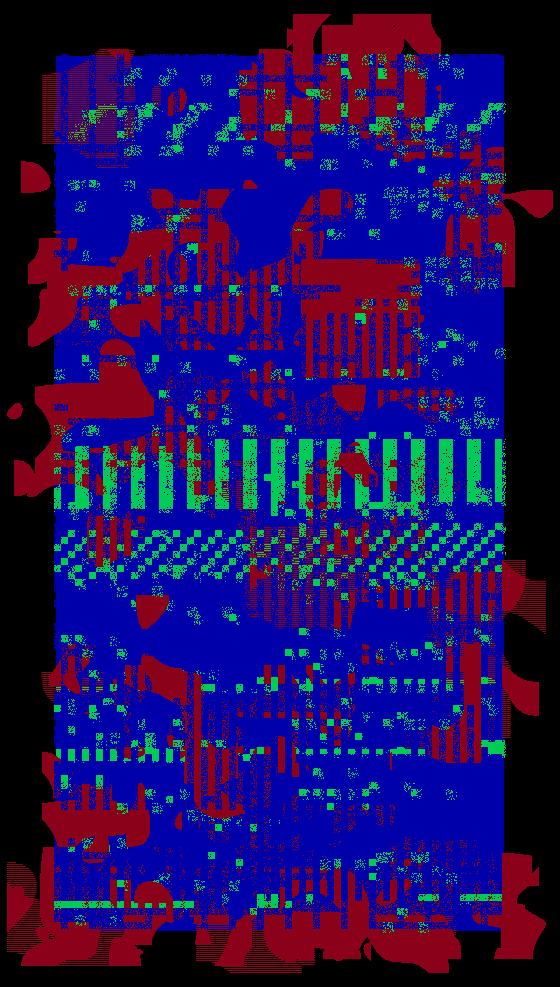

In [12]:
new_img = Image.fromarray(img_arr)
new_img.save("../out/I2/I2_" + str(time.time()) + ".png")
new_img

In [19]:
pygame.init()
Image = pygame.image.fromstring(new_img.tobytes(), new_img.size, new_img.mode)

while True:
    for event in pygame.event.get():
        if event.type == QUIT:
            pygame.quit()
            sys.exit()
 
    pygame.display.update()


error: Display mode not set

In [14]:
myImage

<Surface(560x987x24 SW)>

In [20]:
import pygame
from pygame.locals import *
import sys
 
pygame.init()
 
displaysurface = pygame.display.set_mode((300, 300))
 
mySurface = pygame.Surface((50, 50))
mySurface.fill((0,255,0))
 
mySurface2 = pygame.Surface((100, 50))
mySurface2.fill((0,255,0))
 
while True:
    for event in pygame.event.get():
        if event.type == QUIT:
            pygame.quit()
            sys.exit()
 
    displaysurface.blit(mySurface, (50,50))
    displaysurface.blit(mySurface2, (50,150))
 
    pygame.display.update()

SystemExit: 

/Users/shervinazadi/opt/miniconda3/envs/cw/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2886: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
